# Cheminement

We start from a Volterra equation
$$X_t = x_0 + \int_0^t K(t-s) b(X_s) ds + \int_0^t K(t-s) \sigma (X_s) dW_s$$
where $X_t$ is a $\mathbb{R}^d$-valued process, $(W_t)_{t \geq 0}$ is a $d$-dimensional brownian motion, $b : \mathbb{R}^d \longrightarrow \mathbb{R}^d$ and $\sigma : \mathbb{R}^d \longrightarrow \mathbb{R}^{d \times d}$ have sublinear growth.

The solution of this Volterra equation is given by $X_t = x_0 + \sum_{i=1}^n \gamma_i X_t^i$ where the processes $X^i$ satisfy
$$d X_t^i = - \rho_i X_t^i dt + b(X_t) dt + \sigma (X_t) dW_t \ \ \ \forall i \in [1,n] \ \ (*)$$

We suppose that
$$\forall i \in [1,d], \ \ b_i(x)=b_i^0 + \left( Bx \right)_i, \ \ \sigma (x) = \text{diag} \left( \sigma_1 \sqrt{x_1}, ..., \sigma_d \sqrt{x_d} \right)$$

We do the usual splitting to define a scheme for the process $X$. The infinitesimal generator $\mathcal{L}$ of $(*)$ can be written $\mathcal{L}_1 + \mathcal{L}_2$ where $\mathcal{L}_1$ is the infinitesimal generator associated to
$$d X_t^i = - \rho_i X^i_t dt \ \ \forall i \in [1,n]$$
which can be solved exactly, and $\mathcal{L}_2$ is the infinitesimal generator associated to 
$$dX_t^i = b(X_t) dt + \sigma (X_t) dW_t \ \text{with} \ X_t = x_0 + \sum_{i=1}^n \gamma_i X_t^i \ \ \ \forall i \in [1,n]$$
The processes $X^i_t$ can be written 
$$X_t^i = x^i + \frac{\xi_t^x - x}{G(0)} \ \ \text{with} \ \ x = x_0 + \sum_{i=1}^n \gamma_i x^i$$
where $\xi^x_t$ satisfy the equation
$$\xi_t^x = x + \int_0^t G(0) b(\xi^x_s) ds + \int_0^t G(0) \sigma (\xi_s^x) dW_s$$
which can be written
$$d \xi_t^x = (A-K \xi^x_t) dt + \Sigma \sqrt{D_t} d W_t$$
with 
$$A = G(0) b^0, \ \ K=-G(0)B, \ \ \Sigma = G(0) \text{diag} (\sigma_1,...,\sigma_d) \ \ \text{and} \ \ D_t = \text{diag} (\xi_{1t},..., \xi_{dt})$$
We use the scheme given by Alfonsi for this equation.

In [55]:
# Some useful imports
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [ ]:
class CIR:
    def __init__(self, a, k, sigma):
        self.a = a
        self.k = k
        self.sigma = sigma
    
    def zeta(self, t, k):
        return (1 - np.exp(-k * t)) / k if k != 0 else t

    def w(self, u):
        if u > 5/6:
            return np.sqrt(3)
        if u <= 1/6:
            return -np.sqrt(3)
        return 0

    def u1(self, t, x):
        return x * np.exp(-self.k * t) + self.a * self.zeta(t, self.k)

    def u2(self, t, x):
        term1 = self.u1(t, x)**2
        term2 = self.sigma**2 * self.zeta(t, self.k) * (
            self.a * self.zeta(t, self.k) / 2 + x * np.exp(-self.k * t)
        )
        return term1 + term2

    def pi(self, t, x):
        res = 1 - self.u1(t, x)**2 / self.u2(t, x)
        return (1 - np.sqrt(res)) / 2

    def K2(self, t):
        if self.sigma**2 > 4 * self.a:
            term1 = (self.sigma**2 / 4 - self.a) * self.zeta(t / 2, self.k)
            term2 = np.sqrt(
                np.exp(self.k * t / 2) * (self.sigma**2 / 4 - self.a) * self.zeta(t / 2, self.k)
            ) + self.sigma * np.sqrt(3 * t) / 2
            return np.exp(self.k * t / 2) * (term1 + term2**2)
        else:
            return 0

    def phi(self, x, t, U):
        if(x >= self.K2(t)):
            res = np.exp(-self.k*t/2)* (np.sqrt((self.a-self.sigma**2/4)*self.zeta(t/2, self.k) + np.exp(-self.k*t/2)*x) + self.sigma*np.sqrt(t)*self.w(U)/2)**2
            res += (self.a - self.sigma**2/4) * self.zeta(t/2, self.k)
            return res
        else:
            p = self.pi(t, x)
            if(U < pi):
                return self.u1(t, x) / (2*p)
            else:
                return self.u1(t, x) / (2*(1-p))

class DaiSingleton:
    def __init__(self, A, gamma0, gamma, K, d_prime):
        self.A = A
        self.gamma0 = gamma0
        self.gamma = gamma
        self.K = K
        self.d = len(K)
        self.d_prime = d_prime
        self.K_tilde = K.copy()
        for i in range(d_prime):
            self.K_tilde[i, i] = 0

    def phi(self, x, t, B, Z, U):
        X = expm(-self.K_tilde * (t/2)) @ x
        if(B==1):
            for i in range(self.d_prime):
                modelCIR = CIR(A[i], K[i,i], np.sqrt(gamma[i,i]))
                X[i] = modelCIR.phi(X[i], t, U)
            for i in range(self.d_prime, self.d):
                s = 0
                for j in range(self.d_prime):
                    s += gamma[i][j] * X[j]
                X[i] = X[i] + self.A[i] * t + np.sqrt(self.gamma0[i] + s) * np.sqrt(t) * Z[i]
        else:
            for i in range(self.d_prime, self.d):
                s = 0
                for j in range(self.d_prime):
                    s += gamma[i][j] * X[j]
                X[i] = X[i] + self.A[i] * t + np.sqrt(self.gamma0[i] + s) * np.sqrt(t) * Z[i]
            for i in range(self.d_prime):
                modelCIR = CIR(A[i], K[i,i], np.sqrt(gamma[i,i]))
                X[i] = modelCIR.phi(X[i], t, U)
        X = expm(-self.K_tilde * (t/2)) @ X
        return X

    def simulate_trajectory(self, X0, T, N):
        X = np.zeros((N+1,self.d))
        X[0,:] = X0
        dt = T/N
        for i in range(1, N+1):
            B = np.random.binomial(n=1, p=0.5)
            Z = np.random.randn(self.d)
            U = np.random.rand()
            X[i,:] = self.phi(X[i-1,:], dt, B, Z, U)

        return X

class Volterra:
    def __init__(self, b0, B, sigma, gamma, rho):
        self.b0 = b0
        self.B = B
        self.sigma = sigma
        self.gamma = gamma
        self.rho = rho
        self.d = len(b0)
        self.n = len(gamma)
        self.G0 = sum(gamma)

    def phi1(self, x, t):
        coeffs = np.exp(-self.rho * t) 
        x_new = x * coeffs
        return x_nex


    def phi2(self, x, t, B, Z, U):
        A = self.G0 * self.b0
        K = -self.G0 * self.B
        d_prime = self.d
        gamma0 = np.zeros((self.d, self.d))
        gamma = np.zeros((self.d, self.d))
        for i in range(self.d):
            gamma[i, i] = 1
        modelDaiSingleton = DaiSingleton(A, gamma0, gamma, K, d_prime)
        return modelDaiSingleton.phi(self, x, t, B, Z, U)

    def phi(self, x, t, B, Z, U):
        return self.phi1(self.phi2(self.phi1(x, t/2), t, B, Z, U), t/2)

    def A(self, x, y):
        self.A(x) = 

    def simulate_multifactor(self, T, N, )
        


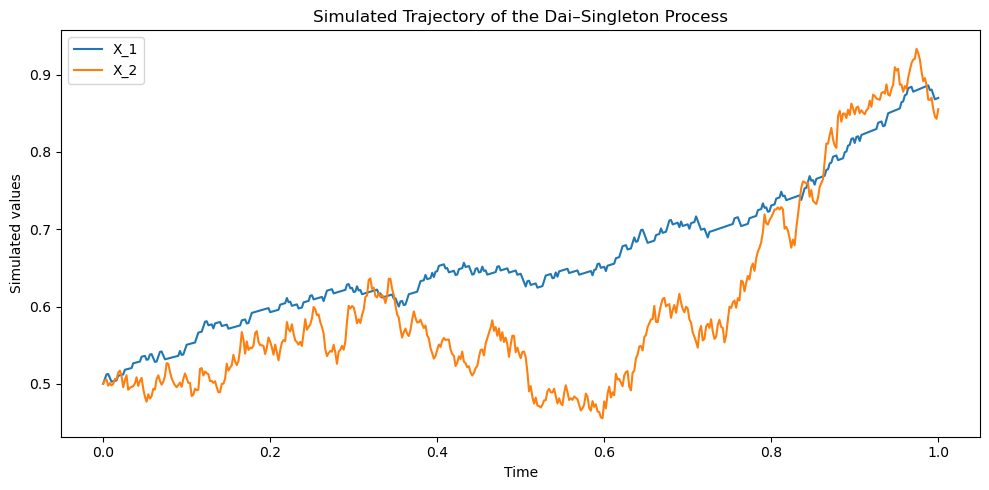

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Model dimension
d = 2                 # Total number of factors
d_prime = 1           # Number of CIR-type factors (first d_prime components)

# Drift vector (A)
A = np.array([0.02, 0.01])

# Constant noise term (gamma0), only applies for i ≥ d_prime
gamma0 = np.array([0.0, 0.04])

# Interaction matrix (gamma): diagonal + lower triangle
gamma = np.array([
    [0.01, 0.0],
    [0.02, 0.0]
])

# Mean-reversion matrix (K)
K = np.array([
    [-0.5, 0.0],  # Row 0 (CIR component): valid since j >= d0 ⇒ 0
    [ 0.1, 0.0]   # Row 1 (Gaussian): valid since j < d0 ⇒ ≥ 0
])

# Initialize Dai–Singleton model
model = DaiSingleton(A, gamma0, gamma, K, d_prime)

# Initial state
X0 = np.ones(d) * 0.5

# Simulation parameters
T = 1.0            # Final time
N = 500            # Number of time steps
dt = T / N

# Simulate a single trajectory
trajectory = model.simulate_trajectory(X0, T, N)

# Time vector for plotting
time = np.linspace(0, T, N + 1)

# Plotting the simulated path
plt.figure(figsize=(10, 5))
for i in range(d):
    plt.plot(time, trajectory[:, i], label=f'X_{i + 1}')
plt.xlabel("Time")
plt.ylabel("Simulated values")
plt.title("Simulated Trajectory of the Dai–Singleton Process")
plt.legend()
plt.tight_layout()
plt.show()

